In [23]:
# 오토글루온 설치
# conda create -n autogluon python=3.11 -y
# conda activate autogluon
# conda install ipython ipykernel

# python -m ipykernel install --user --name autogluon --display-name "autogluon"


# pip install -U pip
# pip install -U setuptools wheel
# pip install autogluon --extra-index-url https://download.pytorch.org/whl/cpu

In [24]:
import pandas as pd
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 대안데이터 불러오기
alter_raw = pd.DataFrame()

# 대안데이터 7월~11월 합치기
for i in range(7,12):
    data = pd.read_csv(f'../alternative_data/대안{i}.csv', encoding='cp949')
    alter_raw = pd.concat([alter_raw, data], axis=0)

alter_raw.shape

(50880, 143)

In [25]:
alter_data = copy.deepcopy(alter_raw)
alter_data.head()

,행정동코드,자치구,행정동,성별,연령대,총인구수,1인가구수,야간상주지 변경 미추정 인구 수,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 25%",...,배달_브랜드 서비스 사용 미추정 인구수,배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 25%","배달_브랜드 서비스 사용일수: 4분위수, 50%","배달_브랜드 서비스 사용일수: 4분위수, 75%",배달_식재료 서비스 사용 미추정 인구수,배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 25%","배달_식재료 서비스 사용일수: 4분위수, 50%","배달_식재료 서비스 사용일수: 4분위수, 75%"
0,1101053,종로구,사직동,1,20,206,64,0,2.5,2,...,181,3.5,1.7,3.3,6.7,204,1.7,1.7,1.7,1.7
1,1101053,종로구,사직동,1,25,341,115,0,2.1,1,...,285,2.8,1.7,1.7,3.3,338,1.7,1.7,1.7,1.7
2,1101053,종로구,사직동,1,30,402,132,0,1.9,1,...,348,3.3,1.7,1.7,5.0,396,1.7,1.7,1.7,1.7
3,1101053,종로구,사직동,1,35,408,125,0,1.9,1,...,344,3.2,1.7,3.3,3.3,400,1.7,1.7,1.7,1.7
4,1101053,종로구,사직동,1,40,399,99,0,1.7,1,...,355,3.0,1.7,1.7,5.0,389,1.7,1.7,1.7,1.7


In [26]:
# 1인가구 비율 산정하여 점수화에 활용
alter_data['1인가구 비율'] = round(alter_data['1인가구수'].str.replace(',','').astype(int) / alter_data['총인구수'].str.replace(',','').astype(int),2)

# 사용하지 않을 컬럼 제거
words_to_drop = ['행정동코드','자치구','행정동','1인가구수', '4분위수, 25%', '4분위수, 75%', 
                 '출근', '근무시간', '카카오톡','통화','문자','이동','집 추정','미추정','인구']

# 
pattern = '|'.join(words_to_drop)
alter_data_clean = alter_data.loc[:, ~alter_data.columns.str.contains(pattern)]
alter_data_clean.head()

,성별,연령대,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",...,"유튜브 사용일수: 4분위수, 50%",넷플릭스 사용일수,"넷플릭스 사용일수: 4분위수, 50%",배달 서비스 사용일수,"배달 서비스 사용일수: 4분위수, 50%",배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 50%",배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 50%",1인가구 비율
0,1,20,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,...,0.4,-0.2,-0.2,11.0,8.3,3.5,3.3,1.7,1.7,0.31
1,1,25,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,...,0.3,-0.2,-0.2,13.6,10.0,2.8,1.7,1.7,1.7,0.34
2,1,30,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,...,0.3,-0.3,-0.5,13.7,11.7,3.3,1.7,1.7,1.7,0.33
3,1,35,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,...,0.2,-0.3,-0.4,13.8,10.0,3.2,3.3,1.7,1.7,0.31
4,1,40,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,...,0.1,-0.3,-0.5,14.3,10.0,3.0,1.7,1.7,1.7,0.25


In [27]:
# alter_data_clean을 복사본으로 생성
alter_data_clean = alter_data_clean.copy()

# 연체여부 데이터 부족으로 평균 이상, 평균이하에 따라 여부 판단
alter_mean = alter_data_clean['최근 3개월 내 요금 연체 비율'].mean()
alter_data_clean.loc[:, '최근 3개월 내 요금 연체 비율'] = alter_data_clean['최근 3개월 내 요금 연체 비율'].apply(lambda x: 1 if x > alter_mean else 0)

# 컬럼 이름 변경
alter_data_clean.rename(columns={'최근 3개월 내 요금 연체 비율': '연체여부'}, inplace=True)

# 연체여부 비율 확인
alter_data_clean['연체여부'].value_counts()

연체여부
0.0    27829
1.0    23051
Name: count, dtype: int64

In [28]:
# 성별 원핫 인코딩
gender = pd.get_dummies(alter_data_clean['성별'])
alter_data_clean = alter_data_clean.drop('성별', axis=1)
alter_data_clean = pd.concat([alter_data_clean,gender], axis=1)

alter_data_clean.rename(columns={1: '남성',2:'여성'}, inplace=True)
alter_data_clean.head()

,연령대,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",연체여부,...,"넷플릭스 사용일수: 4분위수, 50%",배달 서비스 사용일수,"배달 서비스 사용일수: 4분위수, 50%",배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 50%",배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 50%",1인가구 비율,남성,여성
0,20,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,0.0,...,-0.2,11.0,8.3,3.5,3.3,1.7,1.7,0.31,True,False
1,25,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,1.0,...,-0.2,13.6,10.0,2.8,1.7,1.7,1.7,0.34,True,False
2,30,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,1.0,...,-0.5,13.7,11.7,3.3,1.7,1.7,1.7,0.33,True,False
3,35,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,1.0,...,-0.4,13.8,10.0,3.2,3.3,1.7,1.7,0.31,True,False
4,40,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,0.0,...,-0.5,14.3,10.0,3.0,1.7,1.7,1.7,0.25,True,False


In [29]:
# 나이 원핫 인코딩
alter_data_clean['연령대'] = alter_data_clean['연령대'].astype(str).str[0].astype(int)
alter_data_clean['연령대'].head()

age_df = pd.get_dummies(alter_data_clean['연령대'])
alter_data_clean = alter_data_clean.drop('연령대', axis=1)
alter_data_clean = pd.concat([alter_data_clean,age_df], axis=1)

age_keys = [2,3,4,5,6,7]
age_values = ['20대','30대','40대','50대','60대','70대']

alter_data_clean.rename(columns=dict(zip(age_keys,age_values)), inplace=True)
alter_data_clean.head()

,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",연체여부,SNS 사용횟수,...,"배달_식재료 서비스 사용일수: 4분위수, 50%",1인가구 비율,남성,여성,20대,30대,40대,50대,60대,70대
0,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,0.0,0.0,...,1.7,0.31,True,False,True,False,False,False,False,False
1,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,1.0,0.2,...,1.7,0.34,True,False,True,False,False,False,False,False
2,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,1.0,0.2,...,1.7,0.33,True,False,False,True,False,False,False,False
3,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,1.0,0.1,...,1.7,0.31,True,False,False,True,False,False,False,False
4,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,0.0,0.1,...,1.7,0.25,True,False,False,False,True,False,False,False


In [30]:
# 칼럼 순서조정(평균, 중간값 나누기 위해서)
for i in ['연체여부','1인가구 비율']:
    column_move = alter_data_clean.pop(i)
    alter_data_clean.insert(len(alter_data_clean.columns), i, column_move)
alter_data_clean.head()

,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",SNS 사용횟수,"SNS 사용횟수: 4분위수, 50%",...,남성,여성,20대,30대,40대,50대,60대,70대,연체여부,1인가구 비율
0,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,0.0,0.0,...,True,False,True,False,False,False,False,False,0.0,0.31
1,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,0.2,0.2,...,True,False,True,False,False,False,False,False,1.0,0.34
2,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,0.2,0.2,...,True,False,False,True,False,False,False,False,1.0,0.33
3,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,0.1,0.1,...,True,False,False,True,False,False,False,False,1.0,0.31
4,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,0.1,0.1,...,True,False,False,False,True,False,False,False,0.0,0.25


In [31]:
# 중간값 컬럼, 평균값 컬럼 나누기
alter_avg = pd.DataFrame()
alter_mid = pd.DataFrame()

# 중간값, 평균 데이터 분리
for i in range(0, alter_data_clean.shape[1] -10, 2):
    alter_avg[alter_data_clean.columns[i]] = alter_data_clean.iloc[:, i]
    alter_mid[alter_data_clean.columns[i+1]] = alter_data_clean.iloc[:, i+1]

# 기존 데이터와 사분위 50% 차이값 데이터 결합
alter_mid = pd.concat((alter_mid, alter_data_clean.iloc[:,-10:]),axis=1)
alter_avg = pd.concat((alter_avg, alter_data_clean.iloc[:,-10:]),axis=1)

display(alter_avg.head())
display(alter_mid.head())

,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,SNS 사용횟수,데이터 사용량,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,...,남성,여성,20대,30대,40대,50대,60대,70대,연체여부,1인가구 비율
0,2.5,2.5,0.0,5944.4,0.0,21.4,56.8,141.3,123.5,56.6,...,True,False,True,False,False,False,False,False,0.0,0.31
1,2.1,2.2,2.6,7777.8,0.2,19.8,41.3,187.9,174.5,56.0,...,True,False,True,False,False,False,False,False,1.0,0.34
2,1.9,1.8,2.8,5854.2,0.2,17.1,34.0,188.9,181.4,55.9,...,True,False,False,True,False,False,False,False,1.0,0.33
3,1.9,1.7,1.9,6286.7,0.1,13.6,33.2,184.8,189.6,54.8,...,True,False,False,True,False,False,False,False,1.0,0.31
4,1.7,1.7,2.8,6098.0,0.1,11.2,22.5,189.8,199.2,55.2,...,True,False,False,False,True,False,False,False,0.0,0.25


,"야간상주지 변경횟수: 4분위수, 50%","주간상주지 변경횟수: 4분위수, 50%","소액결재 사용횟수: 4분위수, 50%","소액결재 사용금액: 4분위수, 50%","SNS 사용횟수: 4분위수, 50%","데이터 사용량: 4분위수, 50%","게임 서비스 사용일수: 4분위수, 50%","금융 서비스 사용일수: 4분위수, 50%","쇼핑 서비스 사용일수: 4분위수, 50%","동영상/방송 서비스 사용일수: 4분위수, 50%",...,남성,여성,20대,30대,40대,50대,60대,70대,연체여부,1인가구 비율
0,2,2,0.0,3666.7,0.0,16.4,50.0,136.7,106.7,43.3,...,True,False,True,False,False,False,False,False,0.0,0.31
1,2,2,3.3,11000.0,0.2,16.5,25.0,176.7,161.7,53.3,...,True,False,True,False,False,False,False,False,1.0,0.34
2,2,1,3.3,5000.0,0.2,12.2,21.7,186.7,166.7,51.7,...,True,False,False,True,False,False,False,False,1.0,0.33
3,2,1,1.7,5666.7,0.1,8.7,16.7,160.0,153.3,46.7,...,True,False,False,True,False,False,False,False,1.0,0.31
4,1,1,3.3,6333.3,0.1,6.6,10.0,185.0,178.3,50.0,...,True,False,False,False,True,False,False,False,0.0,0.25


In [32]:
alter_avg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50880 entries, 0 to 10175
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   야간상주지 변경횟수 평균    50880 non-null  float64
 1   주간상주지 변경횟수 평균    50880 non-null  float64
 2   소액결재 사용횟수 평균     50880 non-null  float64
 3   소액결재 사용금액 평균     50880 non-null  float64
 4   SNS 사용횟수         50880 non-null  float64
 5   데이터 사용량          50880 non-null  float64
 6   게임 서비스 사용일수      50880 non-null  float64
 7   금융 서비스 사용일수      50880 non-null  float64
 8   쇼핑 서비스 사용일수      50880 non-null  float64
 9   동영상/방송 서비스 사용일수  50880 non-null  float64
 10  유튜브 사용일수         50880 non-null  float64
 11  넷플릭스 사용일수        50880 non-null  float64
 12  배달 서비스 사용일수      50880 non-null  float64
 13  배달_브랜드 서비스 사용일수  50880 non-null  float64
 14  배달_식재료 서비스 사용일수  50880 non-null  float64
 15  남성               50880 non-null  bool   
 16  여성               50880 non-null  bool   
 17  20대              

In [ ]:
alter_avg.corr()['연체여부'].sort_values(ascending=False)

연체여부               1.000000
데이터 사용량            0.484264
동영상/방송 서비스 사용일수    0.468946
게임 서비스 사용일수        0.440614
SNS 사용횟수           0.436468
배달 서비스 사용일수        0.434383
유튜브 사용일수           0.434364
주간상주지 변경횟수 평균      0.423369
금융 서비스 사용일수        0.422127
넷플릭스 사용일수          0.393302
쇼핑 서비스 사용일수        0.377090
소액결재 사용금액 평균       0.311503
야간상주지 변경횟수 평균      0.274868
20대                0.232563
배달_브랜드 서비스 사용일수    0.208086
소액결재 사용횟수 평균       0.203025
30대                0.197813
배달_식재료 서비스 사용일수    0.179026
남성                 0.132148
1인가구 비율            0.116431
40대                0.063689
50대                0.018452
여성                -0.132148
60대               -0.149468
70대               -0.363049
Name: 연체여부, dtype: float64

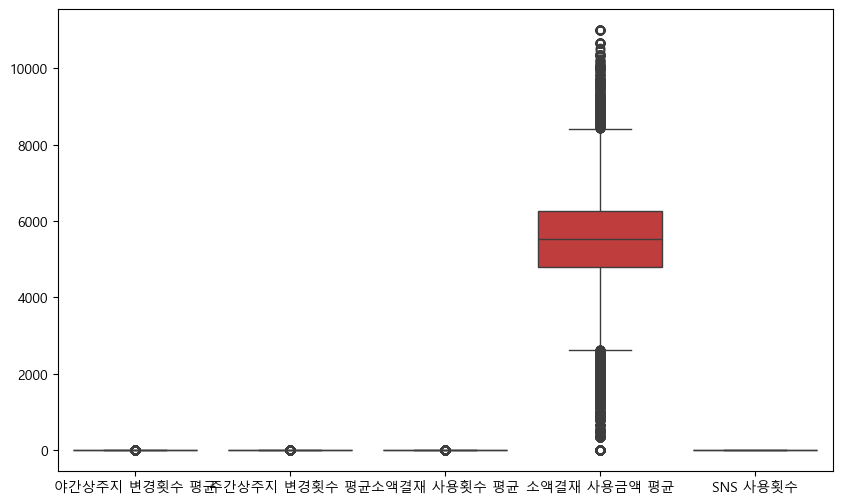

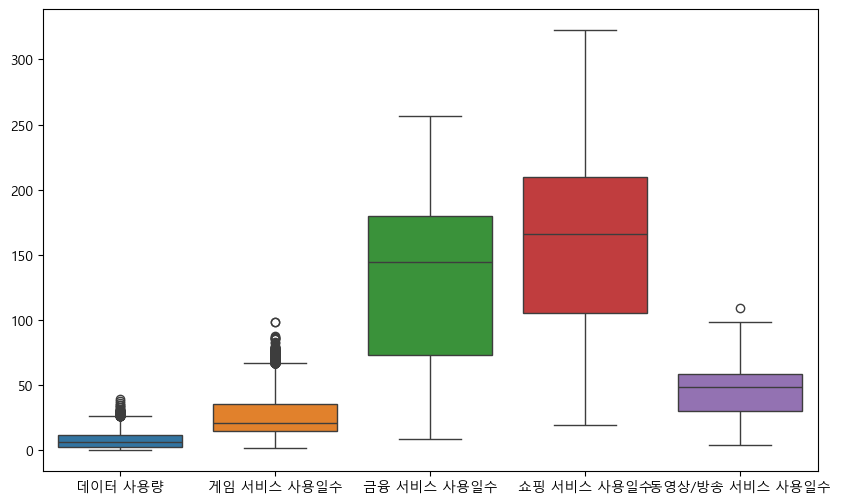

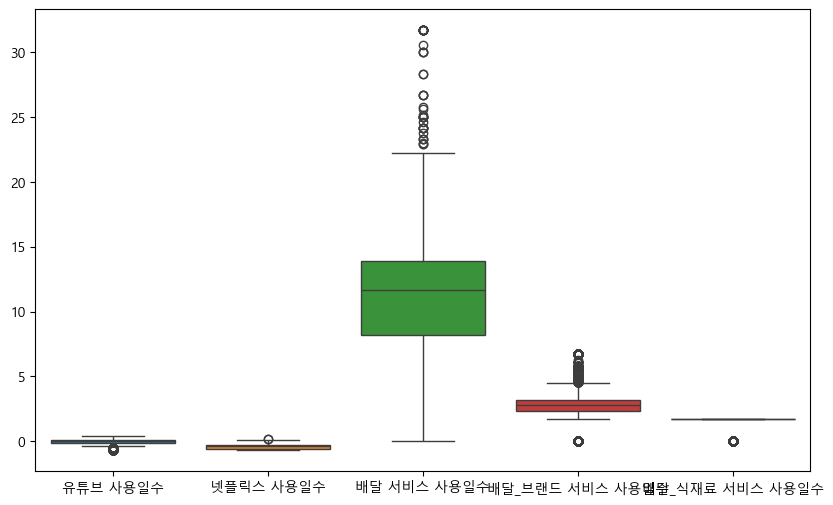

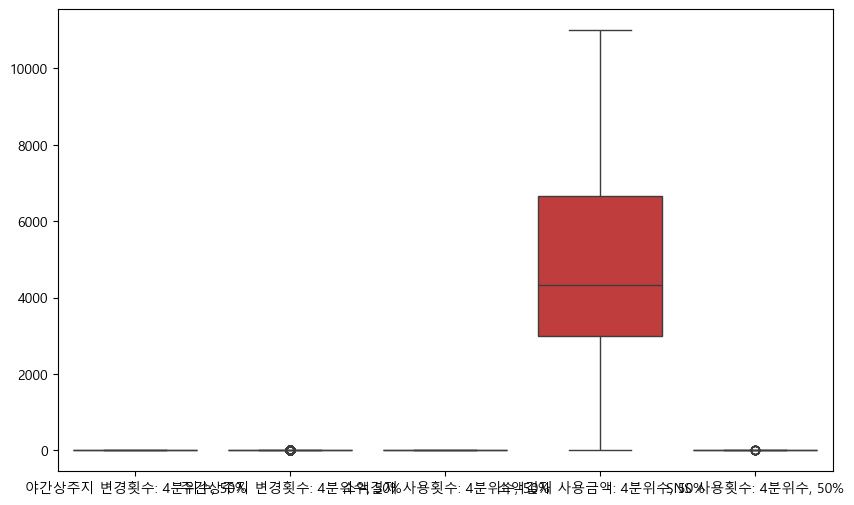

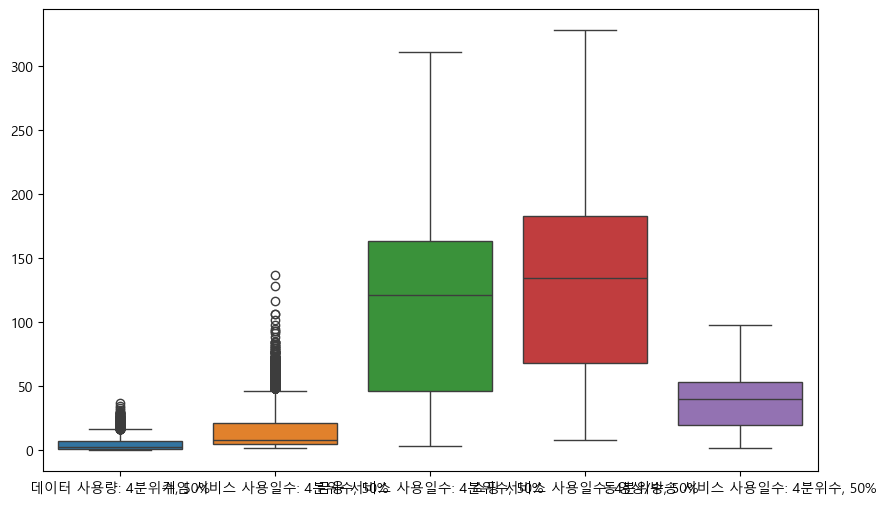

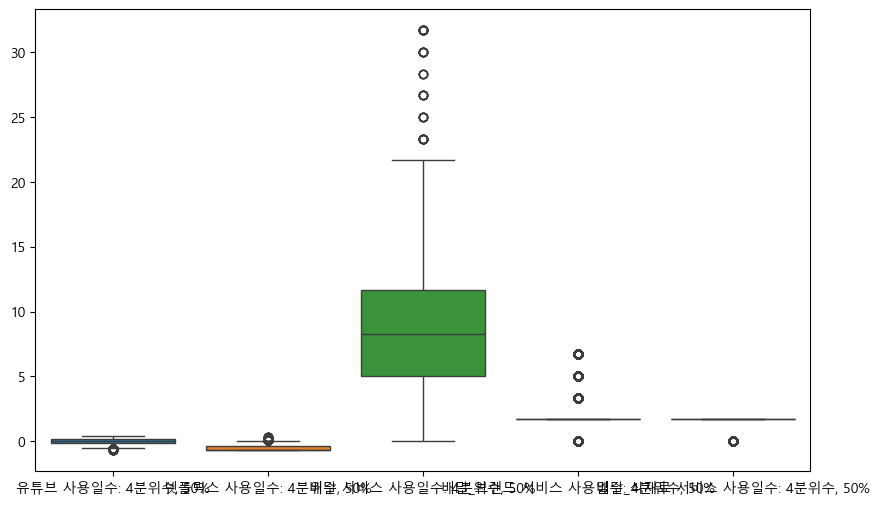

In [34]:
# 아웃라이어 확인 박스플롯
def make_box(data):
    for i in range(3):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data.iloc[:, i*5:(i+1)*5])
        plt.show()

make_box(alter_avg)
make_box(alter_mid)


In [35]:
# 아웃라이어 제거
def remove_outliers(df):
    df_out = df.iloc[:,:15]
    Q1 = df_out.quantile(0.25)
    Q3 = df_out.quantile(0.75)
    IQR = Q3 - Q1
    filter =  ~((df_out < (Q1 - 1.5 * IQR)) | (df_out > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[filter]

alter_avg_cleaned = remove_outliers(alter_avg)
alter_mid_cleaned = remove_outliers(alter_mid)

alter_avg_cleaned.shape, alter_mid_cleaned.shape

((34819, 25), (28330, 25))

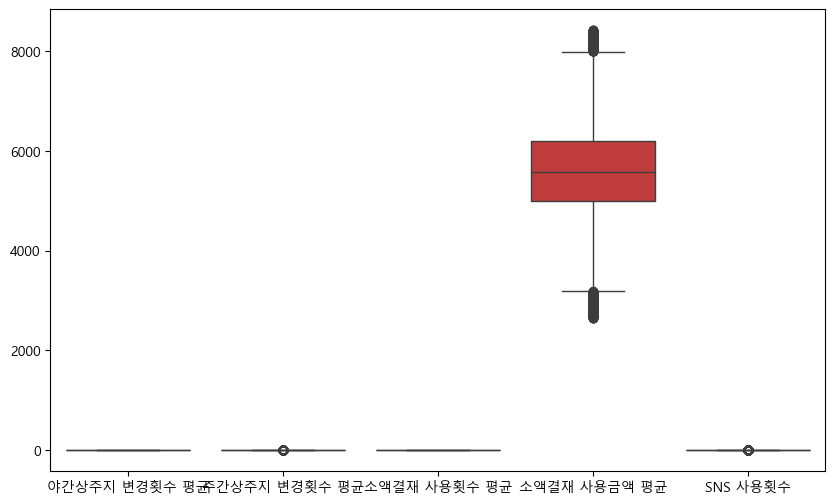

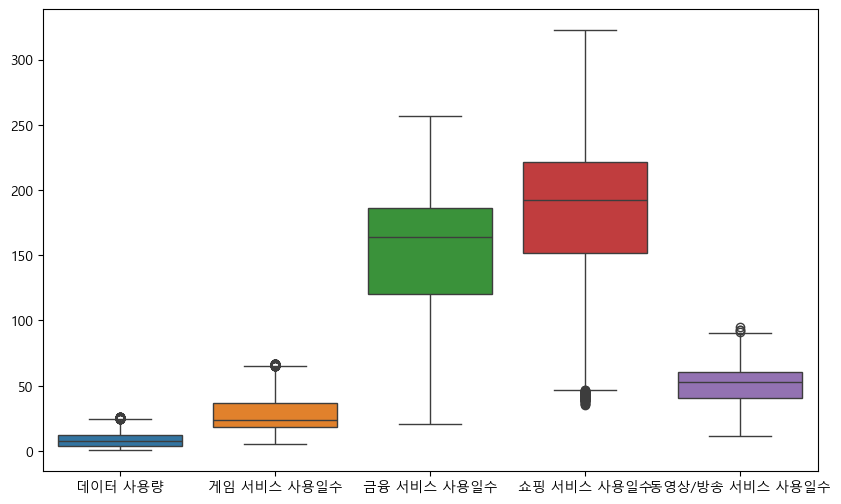

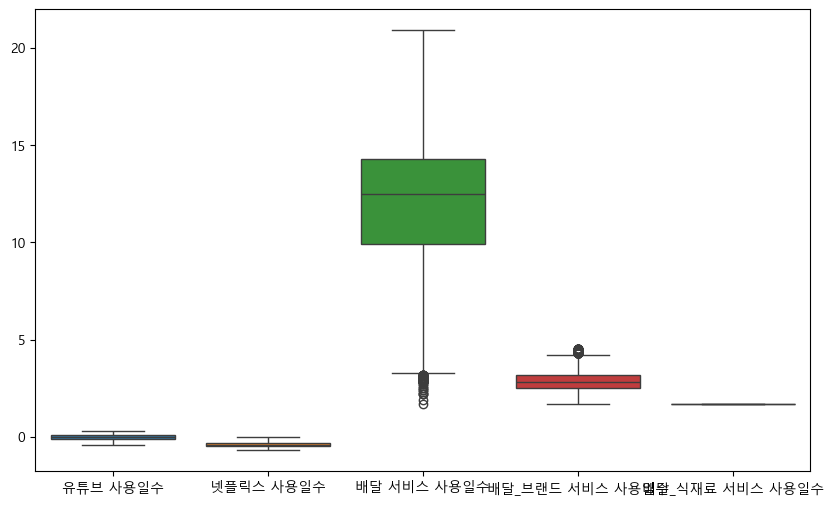

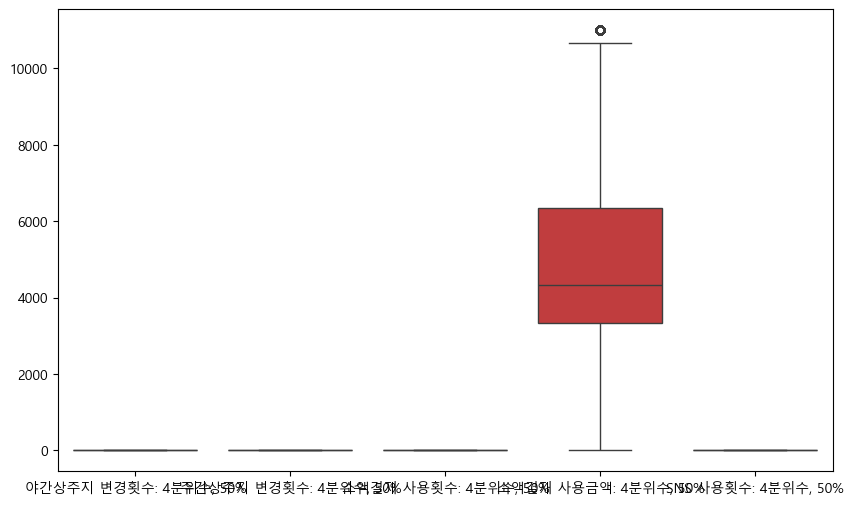

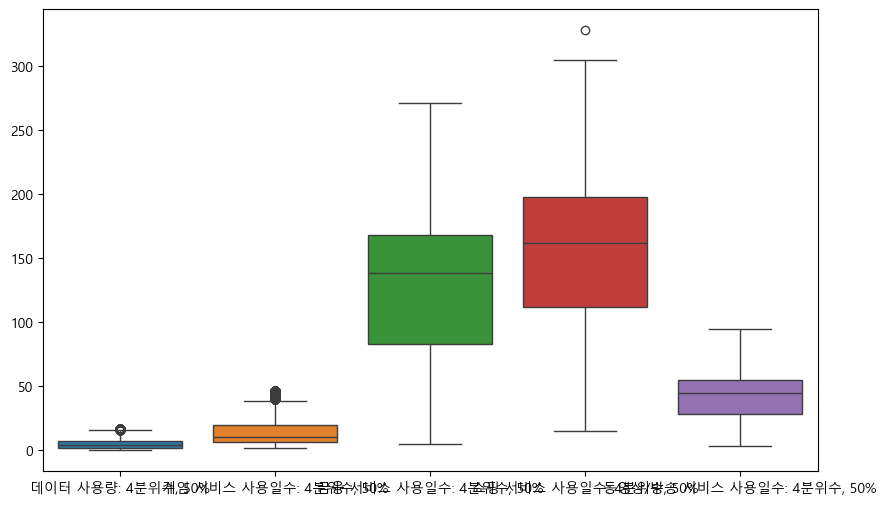

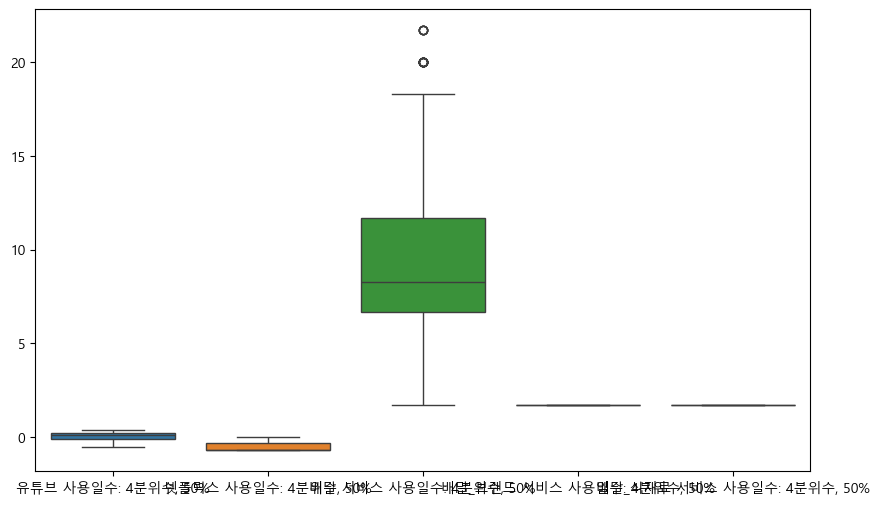

In [36]:
# 아웃라이어 제거 확인
make_box(alter_avg_cleaned)
make_box(alter_mid_cleaned)

In [37]:
# 모델학습 핵심 지표 매핑
alter_avg_mapping = {
    '소비 빈도 및 활동성': [
        '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '소액결재 사용횟수 평균', 
        'SNS 사용횟수', '게임 서비스 사용일수', '쇼핑 서비스 사용일수'
    ],
    '소비 금액 및 규모': [
        '소액결재 사용금액 평균', '데이터 사용량', '유튜브 사용일수', 
        '넷플릭스 사용일수', '배달 서비스 사용일수'
    ],
    '연체 가능성 및 신용 리스크': ['1인가구 비율'
    ],
    '서비스 이용 다양성': [
        '금융 서비스 사용일수', '동영상/방송 서비스 사용일수', 
        '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수'
    ]
}

alter_mid_mapping = {
    '소비 빈도 및 활동성': [
        '야간상주지 변경횟수: 4분위수, 50%', '주간상주지 변경횟수: 4분위수, 50%', 
        '소액결재 사용횟수: 4분위수, 50%', 'SNS 사용횟수: 4분위수, 50%', 
        '게임 서비스 사용일수: 4분위수, 50%', '쇼핑 서비스 사용일수: 4분위수, 50%'
    ],
    '소비 금액 및 규모': [
        '소액결재 사용금액: 4분위수, 50%', '데이터 사용량: 4분위수, 50%', 
        '유튜브 사용일수: 4분위수, 50%', '넷플릭스 사용일수: 4분위수, 50%', 
        '배달 서비스 사용일수: 4분위수, 50%'
    ],
    '연체 가능성 및 신용 리스크': ['1인가구 비율'],
    '서비스 이용 다양성': [
        '금융 서비스 사용일수: 4분위수, 50%', '동영상/방송 서비스 사용일수: 4분위수, 50%', 
        '배달_브랜드 서비스 사용일수: 4분위수, 50%', '배달_식재료 서비스 사용일수: 4분위수, 50%'
    ]
}


In [38]:
# # 정규화(X)
# # 핵심 지표 생성 함수
# def create_core_features(data, mapping):
#     core_features = {}
#     for feature_name, columns in mapping.items():
#         core_features[feature_name] = data[columns].mean(axis=1)  # 평균값으로 통합
#     return pd.DataFrame(core_features)

# alter_avg_index = create_core_features(alter_avg_cleaned, alter_avg_mapping)
# alter_mid_index = create_core_features(alter_mid_cleaned, alter_mid_mapping)

# alter_avg_raw = pd.concat([alter_avg_index, alter_avg_cleaned.iloc[:,15:]], axis=1)
# alter_mid_raw = pd.concat([alter_mid_index, alter_mid_cleaned.iloc[:,15:]], axis=1)

# display(alter_avg_raw.head())
# display(alter_mid_raw.head())

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mscaler = MinMaxScaler()
scaler = StandardScaler()

def create_core_features(data, mapping, scaler):
    core_features = {}
    
    for feature_name, columns in mapping.items():
        # 해당 그룹의 컬럼들 정규화
        scaled_values = scaler.fit_transform(data[columns])
        # 정규화된 값들의 평균 계산
        core_features[feature_name] = np.mean(scaled_values, axis=1)
    
    return pd.DataFrame(core_features)

# 정규화
alter_avg_index = create_core_features(alter_avg_cleaned, alter_avg_mapping, mscaler).reset_index(drop=True)
alter_mid_index = create_core_features(alter_mid_cleaned, alter_mid_mapping, mscaler).reset_index(drop=True)

alter_avg_cleaned = alter_avg_cleaned.reset_index(drop=True)
alter_mid_cleaned = alter_mid_cleaned.reset_index(drop=True)

# 결합 시도
alter_avg_raw = pd.concat([alter_avg_index, alter_avg_cleaned.iloc[:,15:-1]], axis=1)
alter_mid_raw = pd.concat([alter_mid_index, alter_mid_cleaned.iloc[:,15:-1]], axis=1)

# 결과 확인
display(alter_avg_raw.head())
display(alter_mid_raw.head())


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.641394,0.768399,0.383721,0.409465,True,False,True,False,False,False,False,False,1.0
1,0.586476,0.652896,0.372093,0.454870,True,False,False,True,False,False,False,False,1.0
2,0.460871,0.612550,0.348837,0.438317,True,False,False,True,False,False,False,False,1.0
3,0.497903,0.563611,0.279070,0.426953,True,False,False,False,True,False,False,False,0.0
4,0.515722,0.523879,0.267442,0.420061,True,False,False,False,True,False,False,False,0.0


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.640527,0.798901,0.379310,0.297263,True,False,True,False,False,False,False,False,1.0
1,0.547631,0.570208,0.367816,0.302274,True,False,False,True,False,False,False,False,1.0
2,0.403326,0.466734,0.275862,0.296046,True,False,False,False,True,False,False,False,0.0
3,0.407694,0.493575,0.264368,0.256957,True,False,False,False,True,False,False,False,0.0
4,0.469887,0.568360,0.402299,0.251252,False,True,True,False,False,False,False,False,0.0


In [40]:
# !pip install xgboost scikit-learn

In [41]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def data_split(data):
    x = data.drop(columns=['연체여부'])
    y = data['연체여부']

    x_train, x_temp, y_train, y_temp = train_test_split(x,y, test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = data_split(alter_avg_raw)

In [ ]:
# 하이퍼파라미터 그리드 설정
def xgb_grid_model(x_train, x_val, y_train, y_val):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7], 
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # XGBClassifier 초기화
    xgb_model = XGBClassifier(objective='binary:logistic', 
                            random_state=42,
                            scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

    # GridSearchCV 초기화
    grid_search = GridSearchCV(estimator=xgb_model, 
                            param_grid=param_grid, 
                            scoring='precision', 
                            cv=3)

    # GridSearchCV 실행
    grid_search.fit(x_train, y_train)

    # 최적의 하이퍼파라미터 출력
    print("최적의 하이퍼파라미터:", grid_search.best_params_)
    print("최적의 precision 점수:", grid_search.best_score_)

    # 최적의 하이퍼파라미터로 모델 재훈련
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(x_train, y_train, 
                    eval_set=[(x_val, y_val)])
    
    return best_xgb_model
    
best_xgb_model = xgb_grid_model(x_train, x_val, y_train, y_val)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\ENVY\anaconda3\envs\autogluon\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


최적의 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
최적의 precision 점수: 0.7663678903539474
[0]	validation_0-logloss:0.66381
[1]	validation_0-logloss:0.63966
[2]	validation_0-logloss:0.61903
[3]	validation_0-logloss:0.60368
[4]	validation_0-logloss:0.58904
[5]	validation_0-logloss:0.57665
[6]	validation_0-logloss:0.57042
[7]	validation_0-logloss:0.56045
[8]	validation_0-logloss:0.55145
[9]	validation_0-logloss:0.54392
[10]	validation_0-logloss:0.53845
[11]	validation_0-logloss:0.53247
[12]	validation_0-logloss:0.52781
[13]	validation_0-logloss:0.52408
[14]	validation_0-logloss:0.52012
[15]	validation_0-logloss:0.51663
[16]	validation_0-logloss:0.51491
[17]	validation_0-logloss:0.51200
[18]	validation_0-logloss:0.50922
[19]	validation_0-logloss:0.50615
[20]	validation_0-logloss:0.50407
[21]	validation_0-logloss:0.50196
[22]	validation_0-logloss:0.50013
[23]	validation_0-logloss:0.49859
[24]	validation_0-

Accuracy: 0.7683802412406663
Precision: 0.759205298013245
Recall: 0.8028011204481793
F1-score: 0.7803948264125256
ROC AUC: 0.8491045327972084


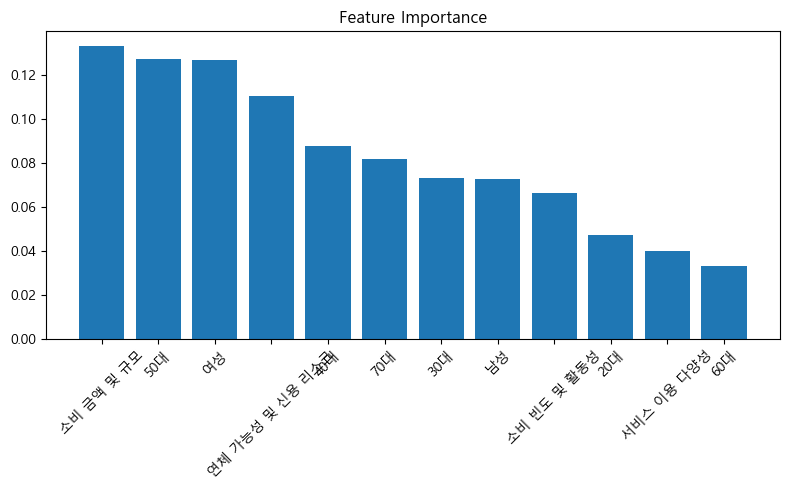

In [43]:
#  평가 함수
def evaluate_model(model, x_val, y_val):
    y_pred = model.predict(x_val)
    y_pred_proba = model.predict_proba(x_val)

    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Precision:', precision_score(y_val, y_pred))
    print('Recall:', recall_score(y_val, y_pred))
    print('F1-score:', f1_score(y_val, y_pred))
    print('ROC AUC:', roc_auc_score(y_val, y_pred_proba[:, 1]))

    # 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': x_val.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(8, 5))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return y_pred, y_pred_proba
    
y_pred, y_pred_proba = evaluate_model(best_xgb_model, x_val, y_val)

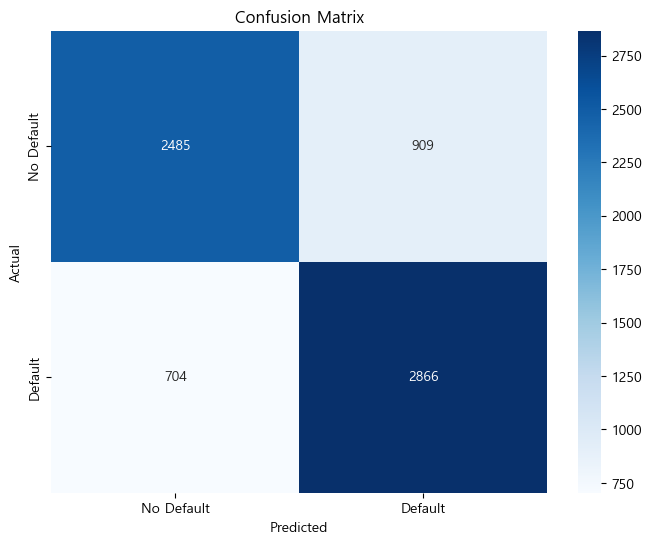

In [44]:
def confusion_mt(y_val, y_pred):
    # 혼동행렬 생성
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
  
confusion_mt(y_val, y_pred)

Accuracy: 0.7637851809304997
Precision: 0.7663329820864068
Recall: 0.7932915189528225
F1-score: 0.7795792576711779
ROC AUC: 0.8458569280532774


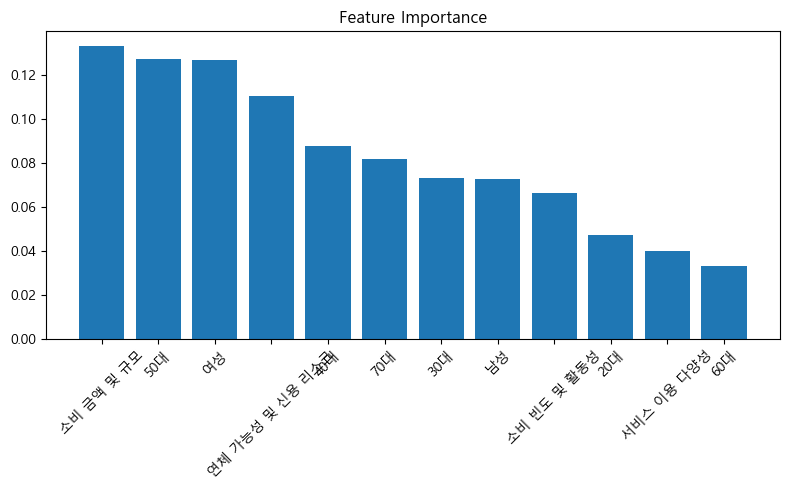

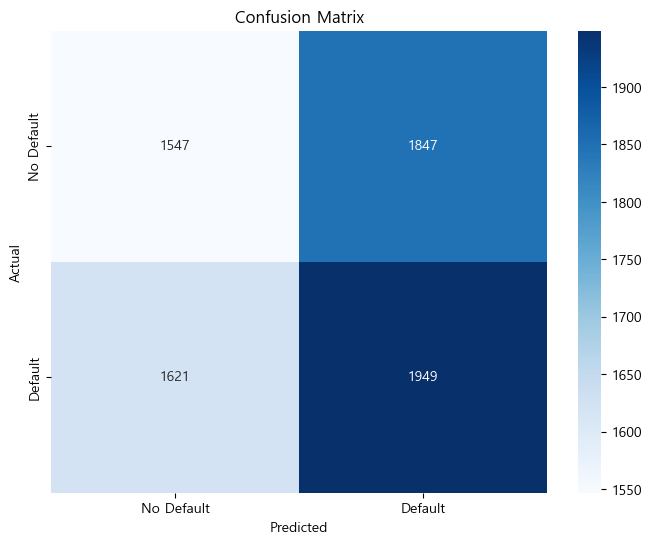

In [45]:
# 테스트 예측
y_pred, y_pred_proba = evaluate_model(best_xgb_model, x_test, y_test)
confusion_mt(y_val, y_pred)

In [46]:
# 신용카드 예측 데이터 불러오기
predict_data = pd.read_csv('../alternative_data/credit.csv', encoding='utf-8')
predict_data.rename(columns={'회원여부_연체': '연체여부'}, inplace=True)
x_test_p = predict_data.drop(['연체여부'],axis=1)
y_test_p = predict_data['연체여부']

Accuracy: 0.9616563333333333
Precision: 0.009760293182753076
Recall: 0.008339590689054687
F1-score: 0.008994184794314021
ROC AUC: 0.42281184774867264


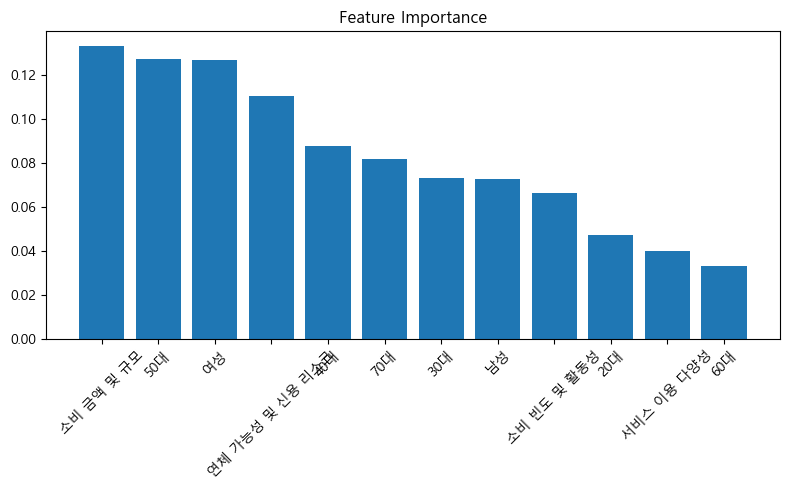

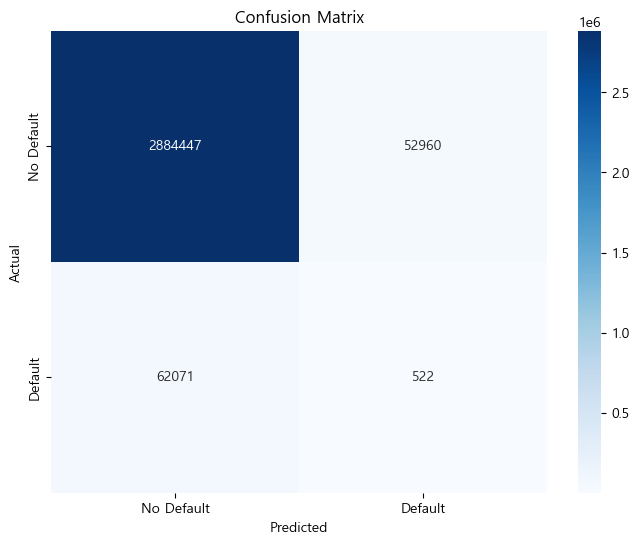

In [47]:
# XGB모델 예측
y_pred_p, y_pred_proba_p = evaluate_model(best_xgb_model,  x_test_p, y_test_p)
confusion_mt(y_test_p, y_pred_p)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def rf_grid_model(x_train, x_val, y_train, y_val):
    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5], 
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': [0.8, 1.0],
        'bootstrap': [True, False]
    }
    
    # 랜덤포레스트 모델 초기화
    rf_model = RandomForestClassifier(random_state=42)

    # GridSearchCV 초기화
    grid_search_rf = GridSearchCV(estimator=rf_model, 
                                  param_grid=param_grid, 
                                  scoring='recall', 
                                  cv=3,
                                  n_jobs=-1)  # 병렬 처리 활성화
    
    # GridSearchCV 실행
    grid_search_rf.fit(x_train, y_train)

    # 최적의 하이퍼파라미터 출력
    print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
    print("최적의 AUC 점수:", grid_search_rf.best_score_)

    # 최적의 하이퍼파라미터로 모델 재훈련
    best_rf_model = grid_search_rf.best_estimator_
    best_rf_model.fit(x_train, y_train)
    
    
    return best_rf_model

# 함수 호출
grid_search_rf = rf_grid_model(x_train, x_val, y_train, y_val)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
최적의 하이퍼파라미터: {'bootstrap': False, 'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
최적의 AUC 점수: 0.8500094807740585


Accuracy: 0.7321941412981046
Precision: 0.6966551326412919
Recall: 0.84593837535014
F1-score: 0.7640733712839974
ROC AUC: 0.8047446556701643


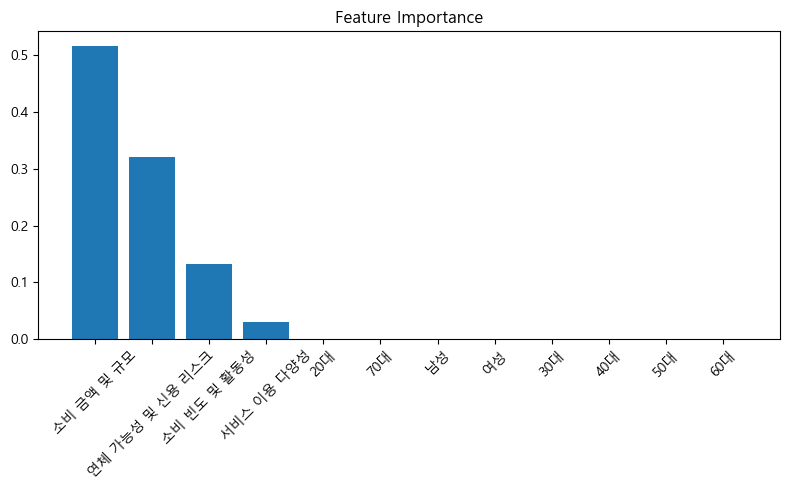

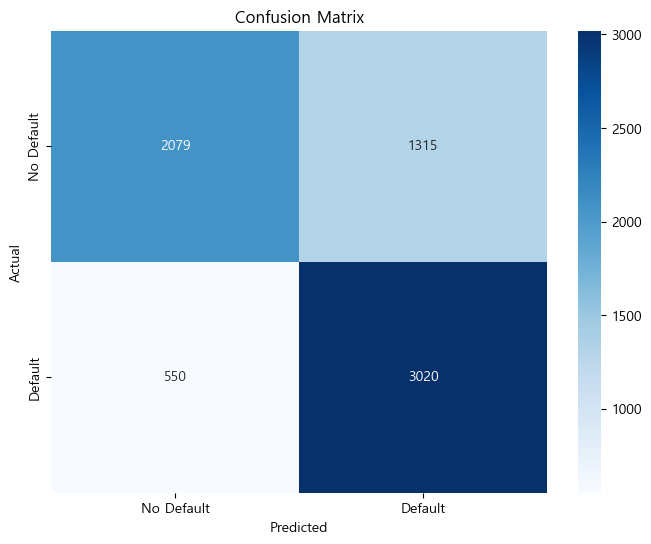

In [55]:
# 평가
y_pred_rf, y_pred_proba_rf = evaluate_model(grid_search_rf, x_val, y_val)
confusion_mt(y_val, y_pred_rf)

Accuracy: 0.9763936666666667
Precision: 0.011752136752136752
Recall: 0.0015816465099931303
F1-score: 0.0027880648295478547
ROC AUC: 0.5598701513945211


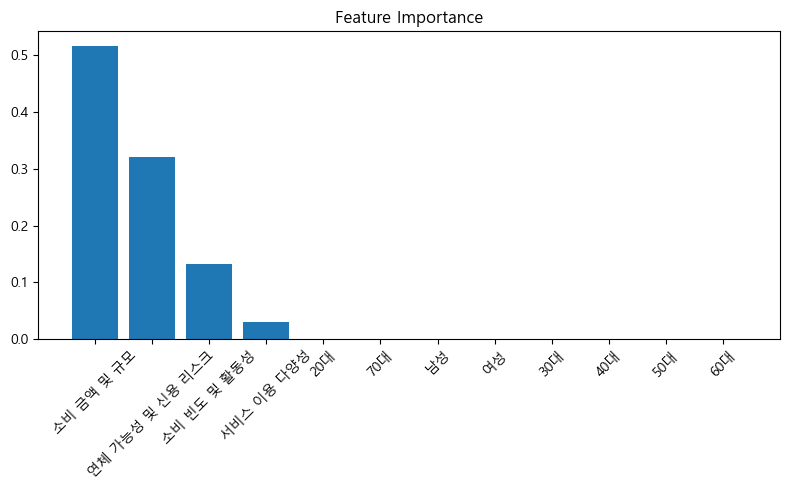

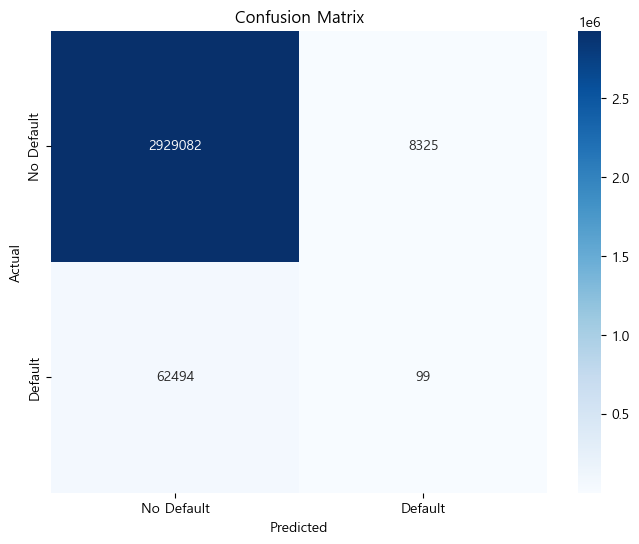

In [58]:
# 랜덤포래스트 모델 예측
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(grid_search_rf, x_test_p, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

테스트 데이터 균형 라벨 균형 맞추기

In [59]:
# 라벨 균형을 보정(다른 연도 연체자 데이터 추가, 비연체자 데이터 축소)
balence_test_df = pd.read_csv('../alternative_data/credit(120만).csv')
balence_test_df.rename(columns={'회원여부_연체':'연체여부'}, inplace=True)
balence_test_df.head()

,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.384426,0.077502,0.5,0.25,0,1,0,0,1,0,0,0,1
1,0.265004,0.042410,1.0,0.25,0,1,1,0,0,0,0,0,1
2,0.076045,0.038398,0.5,0.25,0,1,0,0,0,1,0,0,1
3,0.119652,0.045946,0.5,0.25,0,1,0,1,0,0,0,0,1
4,0.168577,0.040089,0.5,0.25,1,0,0,0,0,0,1,0,1


In [60]:
balence_test_df['연체여부'].value_counts(normalize=True)

연체여부
0    0.742411
1    0.257589
Name: proportion, dtype: float64

In [61]:
x_test_p = balence_test_df.drop(['연체여부'], axis=1)
y_test_p = balence_test_df['연체여부']
print(x_test_p.shape, y_test_p.shape)

(1200000, 12) (1200000,)


Accuracy: 0.7325616666666667
Precision: 0.10062850577819828
Recall: 0.004817102168504757
F1-score: 0.00919408219719423
ROC AUC: 0.4164082660008982


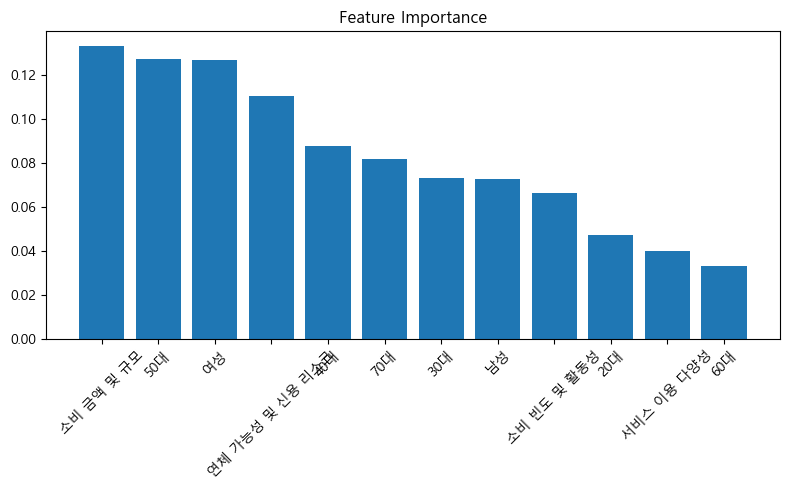

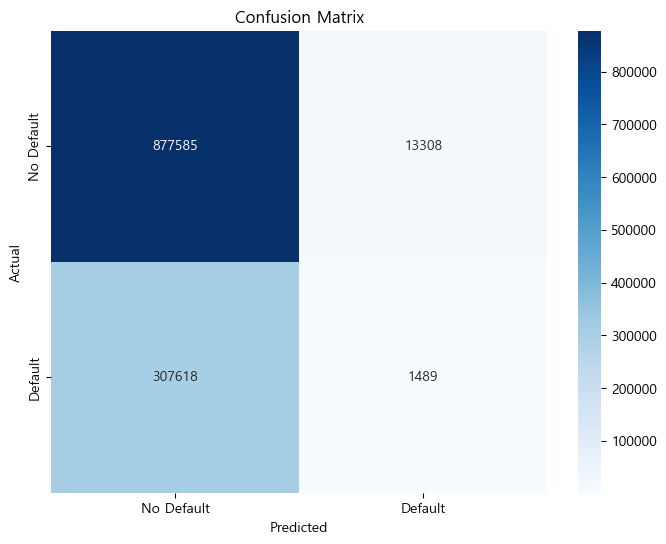

In [62]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(best_xgb_model, x_test_p, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

Accuracy: 0.7423983333333334
Precision: 0.14285714285714285
Recall: 9.705377102427314e-06
F1-score: 1.940943557361352e-05
ROC AUC: 0.5605119444261895


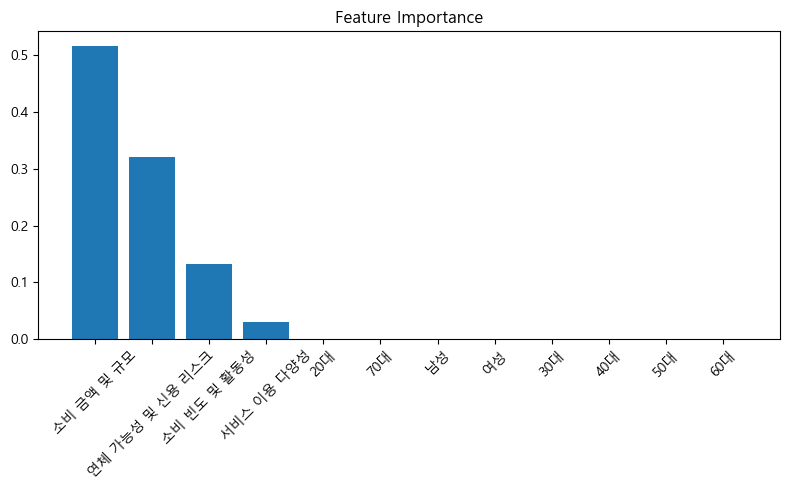

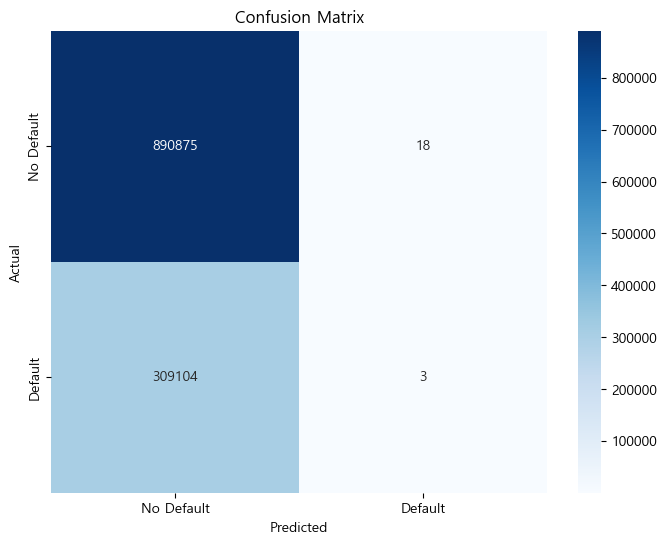

In [64]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(grid_search_rf,  x_test_p, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

성별, 나이대 제거

In [65]:
# 대안신용평가 데이터
x_train_wo = x_train.iloc[:,:4]
x_val_wo = x_val.iloc[:,:4]
x_test_wo = x_test.iloc[:,:4]

display(x_train_wo.head())
display(x_val_wo.head())
display(x_test_wo.head())

,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성
962,0.349502,0.220048,0.255814,0.213550
16166,0.470327,0.418798,0.069767,0.404193
23200,0.462015,0.457325,0.104651,0.371452
27341,0.658718,0.690702,0.372093,0.471920
12952,0.432120,0.459275,0.337209,0.360276


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성
14948,0.367945,0.344969,0.081395,0.189106
6639,0.590384,0.617766,0.186047,0.476003
31806,0.626003,0.645488,0.046512,0.429847
22665,0.367895,0.355471,0.104651,0.339005
7932,0.328493,0.260941,0.290698,0.165297


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성
16250,0.352040,0.304136,0.127907,0.328674
10901,0.565576,0.591488,0.104651,0.490071
2702,0.458827,0.549072,0.197674,0.435529
740,0.597816,0.759498,0.348837,0.499561
23673,0.370016,0.194426,0.151163,0.152012


In [66]:
# 신용카드 이용 데이터
x_test_p_wo = x_test_p.iloc[:,:4]
display(x_test_p_wo.head())

,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성
0,0.384426,0.077502,0.5,0.25
1,0.265004,0.042410,1.0,0.25
2,0.076045,0.038398,0.5,0.25
3,0.119652,0.045946,0.5,0.25
4,0.168577,0.040089,0.5,0.25


xgb

In [67]:
# xgb모델
xgb_wo_model = xgb_grid_model(x_train_wo, x_val_wo, y_train, y_val)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\ENVY\anaconda3\envs\autogluon\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


최적의 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
최적의 precision 점수: 0.7428169585815588
[0]	validation_0-logloss:0.66837
[1]	validation_0-logloss:0.65352
[2]	validation_0-logloss:0.63435
[3]	validation_0-logloss:0.61858
[4]	validation_0-logloss:0.60617
[5]	validation_0-logloss:0.59788
[6]	validation_0-logloss:0.58814
[7]	validation_0-logloss:0.57993
[8]	validation_0-logloss:0.57304
[9]	validation_0-logloss:0.56696
[10]	validation_0-logloss:0.56218
[11]	validation_0-logloss:0.55636
[12]	validation_0-logloss:0.55275
[13]	validation_0-logloss:0.54778
[14]	validation_0-logloss:0.54402
[15]	validation_0-logloss:0.54093
[16]	validation_0-logloss:0.53870
[17]	validation_0-logloss:0.53561
[18]	validation_0-logloss:0.53281
[19]	validation_0-logloss:0.53067
[20]	validation_0-logloss:0.52869
[21]	validation_0-logloss:0.52693
[22]	validation_0-logloss:0.52517
[23]	validation_0-logloss:0.52428
[24]	validation_0-

Accuracy: 0.7512923607122344
Precision: 0.7346782431052093
Recall: 0.8058823529411765
F1-score: 0.7686347849318729
ROC AUC: 0.8263723344376054


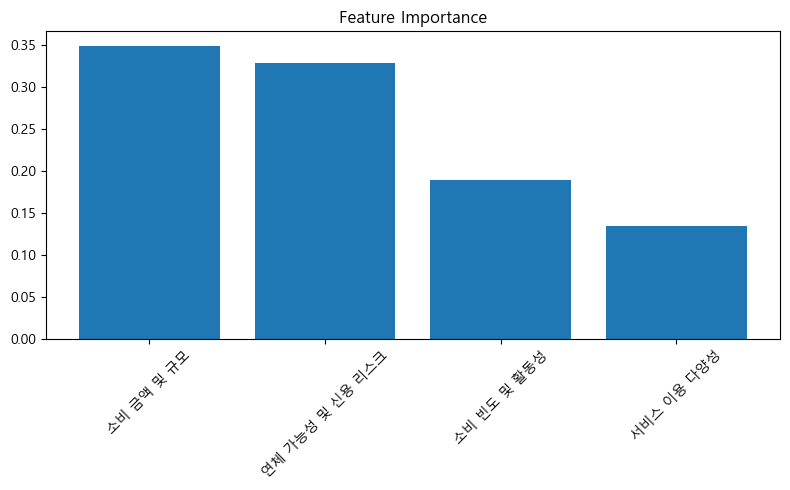

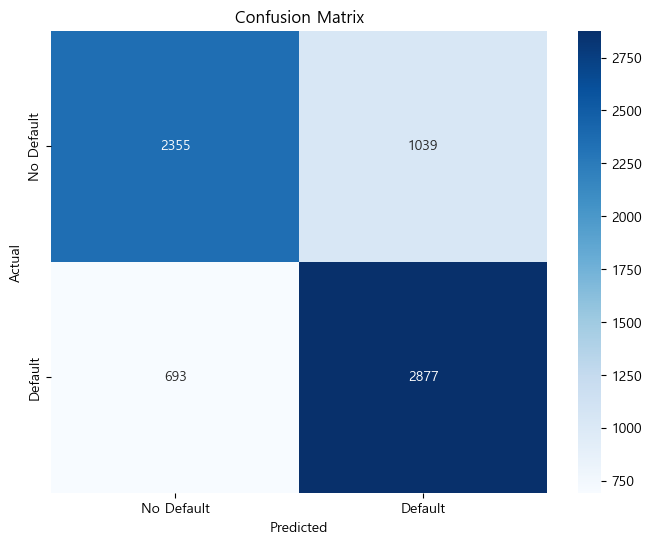

In [68]:
# val 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(xgb_wo_model,  x_val_wo, y_val)
confusion_mt(y_val, y_pred_rf_p)

Accuracy: 0.7459793222286043
Precision: 0.7429595494111623
Recall: 0.7913826015816744
F1-score: 0.7664069721378581
ROC AUC: 0.8167357852073833


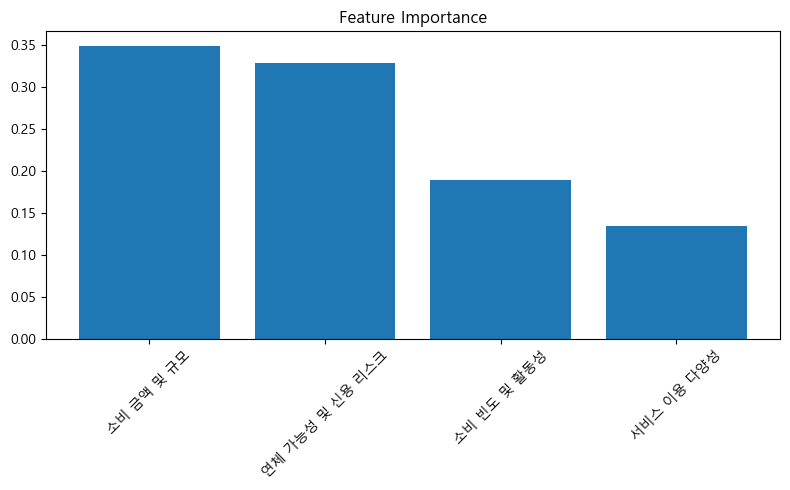

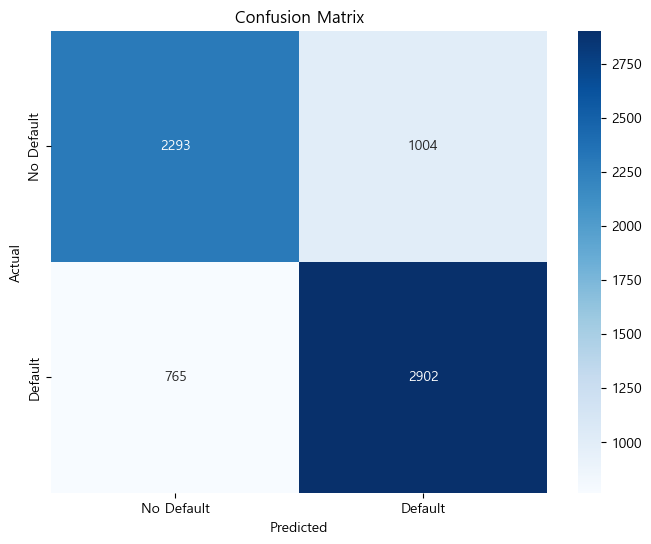

In [69]:
# test 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(xgb_wo_model,  x_test_wo, y_test)
confusion_mt(y_test, y_pred_rf_p)

Accuracy: 0.7420933333333334
Precision: 0.08131868131868132
Recall: 0.00011969965092993688
F1-score: 0.00023904742830192335
ROC AUC: 0.5191696189188701


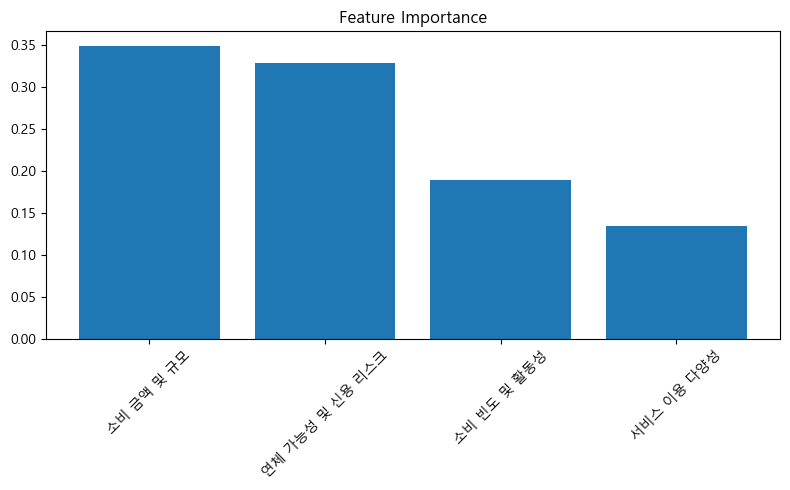

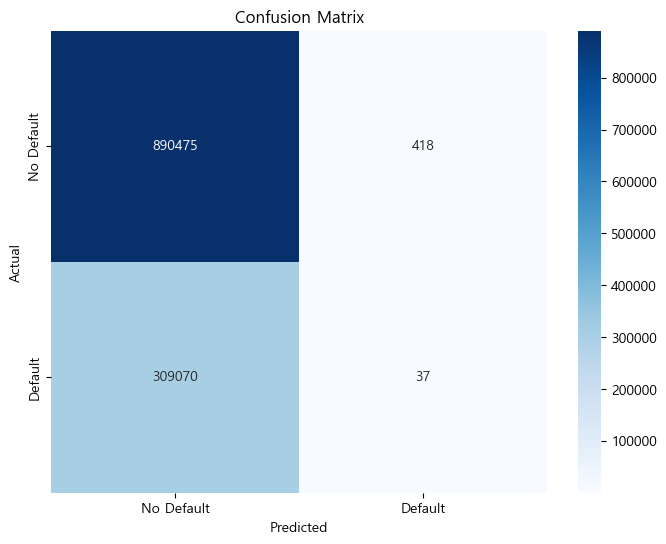

In [71]:
# 신용카드 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(xgb_wo_model,  x_test_p_wo, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

rf모델

In [72]:
# rf모델
rf_wo_model = rf_grid_model(x_train_wo, x_val_wo, y_train, y_val)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
최적의 AUC 점수: 0.849827704117554


Accuracy: 0.7298966111430213
Precision: 0.6929403701165182
Recall: 0.8495798319327731
F1-score: 0.7633069082672707
ROC AUC: 0.8030116584052596


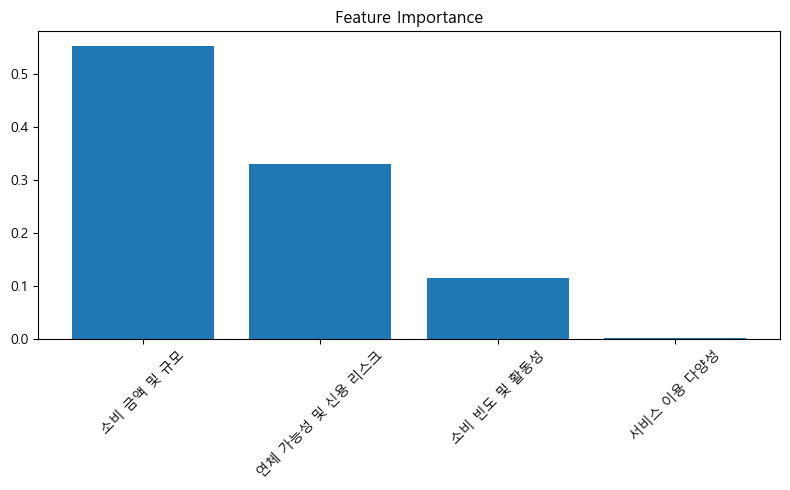

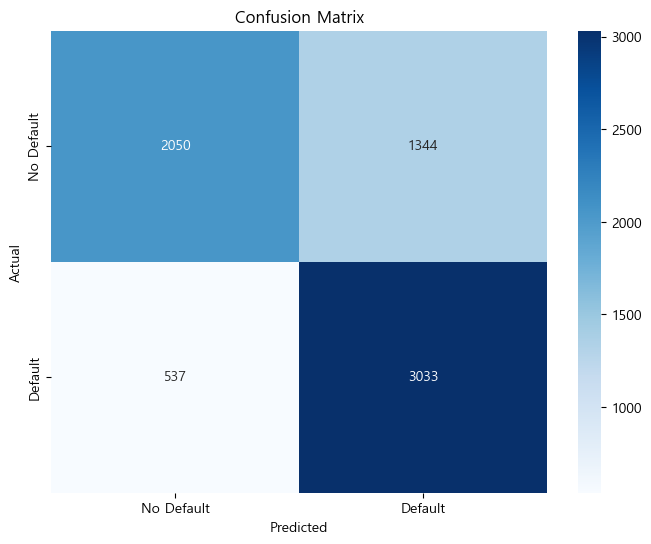

In [73]:
# val 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(rf_wo_model,  x_val_wo, y_val)
confusion_mt(y_val, y_pred_rf_p)

Accuracy: 0.7336300976450316
Precision: 0.7046995029371893
Recall: 0.8505590400872648
F1-score: 0.7707895712344001
ROC AUC: 0.799757222831674


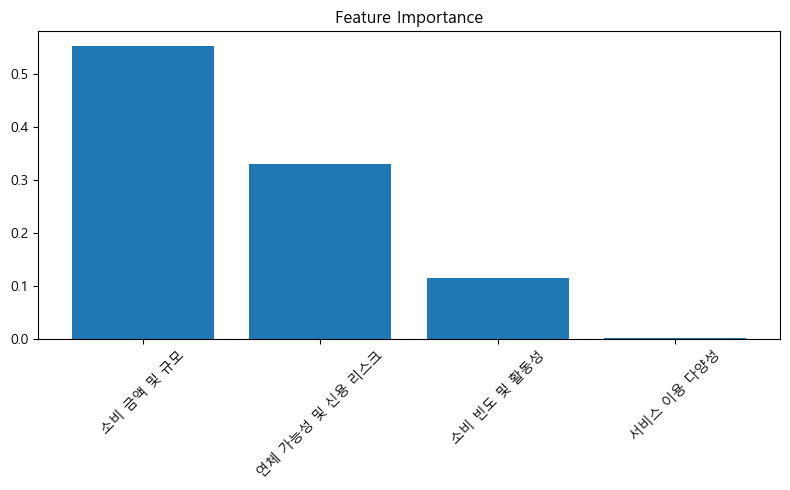

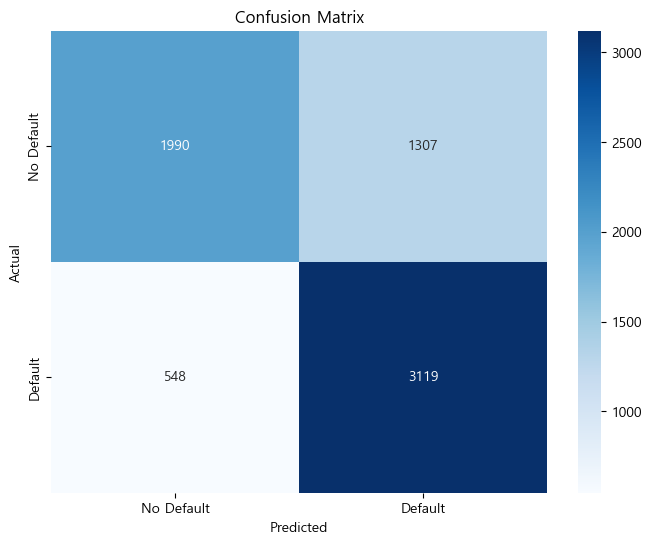

In [74]:
# test 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(rf_wo_model,  x_test_wo, y_test)
confusion_mt(y_test, y_pred_rf_p)

Accuracy: 0.7423941666666667
Precision: 0.11538461538461539
Recall: 9.705377102427314e-06
F1-score: 1.9409121640200174e-05
ROC AUC: 0.5429894712273953


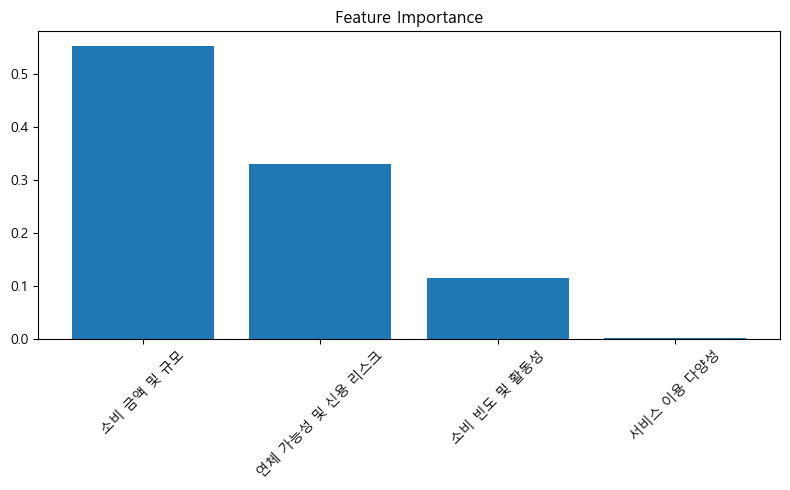

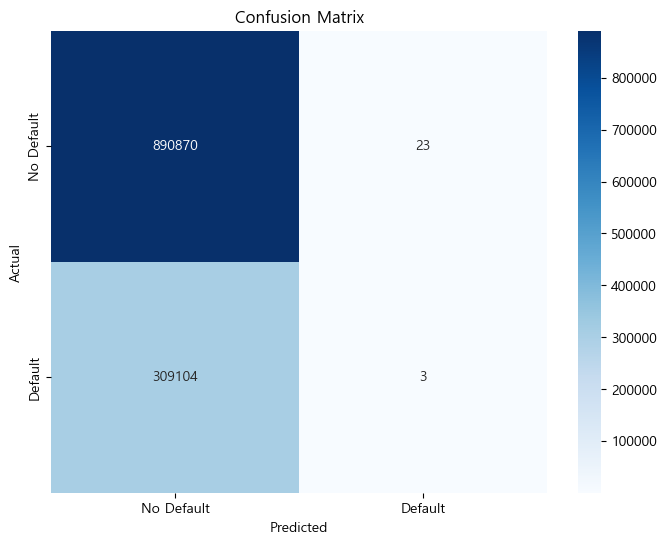

In [75]:
# 신용카드 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(rf_wo_model,  x_test_p_wo, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

In [88]:
# xgb모델(중요도 기준 데이터 변경)
data_list = [x_train_wo, x_val_wo, x_test_wo, x_test_p_wo]
for i in range(len(data_list)):
    data_list[i] = data_list[i].drop(data_list[i].columns[3], axis=1)

x_train_ipt, x_val_ipt, x_test_ipt, x_test_p_ipt =data_list
x_train_ipt.head()


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크
962,0.349502,0.220048,0.255814
16166,0.470327,0.418798,0.069767
23200,0.462015,0.457325,0.104651
27341,0.658718,0.690702,0.372093
12952,0.432120,0.459275,0.337209


In [89]:
xgb_ipt_model = xgb_grid_model(x_train_ipt, x_val_ipt, y_train, y_val)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\ENVY\anaconda3\envs\autogluon\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


최적의 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
최적의 precision 점수: 0.7414999291807066
[0]	validation_0-logloss:0.69058
[1]	validation_0-logloss:0.68806
[2]	validation_0-logloss:0.68516
[3]	validation_0-logloss:0.68230
[4]	validation_0-logloss:0.68049
[5]	validation_0-logloss:0.67873
[6]	validation_0-logloss:0.67699
[7]	validation_0-logloss:0.67528
[8]	validation_0-logloss:0.67264
[9]	validation_0-logloss:0.67001
[10]	validation_0-logloss:0.66842
[11]	validation_0-logloss:0.66626
[12]	validation_0-logloss:0.66472
[13]	validation_0-logloss:0.66319
[14]	validation_0-logloss:0.66075
[15]	validation_0-logloss:0.65867
[16]	validation_0-logloss:0.65631
[17]	validation_0-logloss:0.65435
[18]	validation_0-logloss:0.65294
[19]	validation_0-logloss:0.65156
[20]	validation_0-logloss:0.64967
[21]	validation_0-logloss:0.64781
[22]	validation_0-logloss:0.64599
[23]	validation_0-logloss:0.64469
[24]	validation_0

Accuracy: 0.7416714531878231
Precision: 0.7330876546459595
Recall: 0.7801120448179272
F1-score: 0.7558691817071516
ROC AUC: 0.8161999508112026


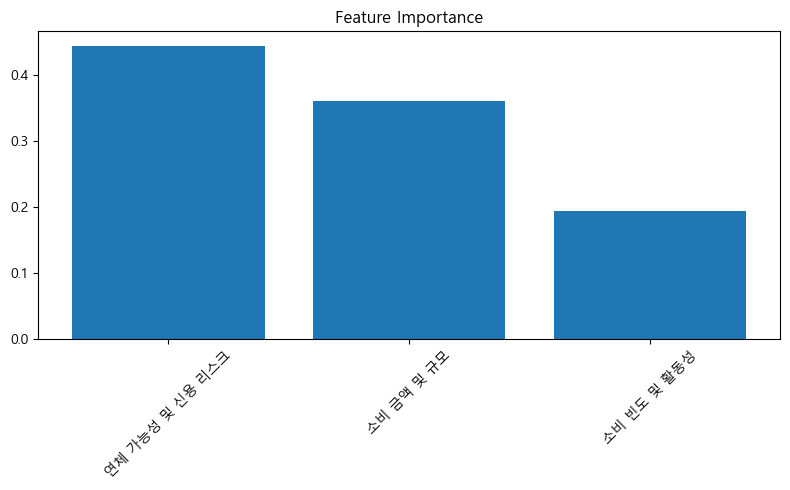

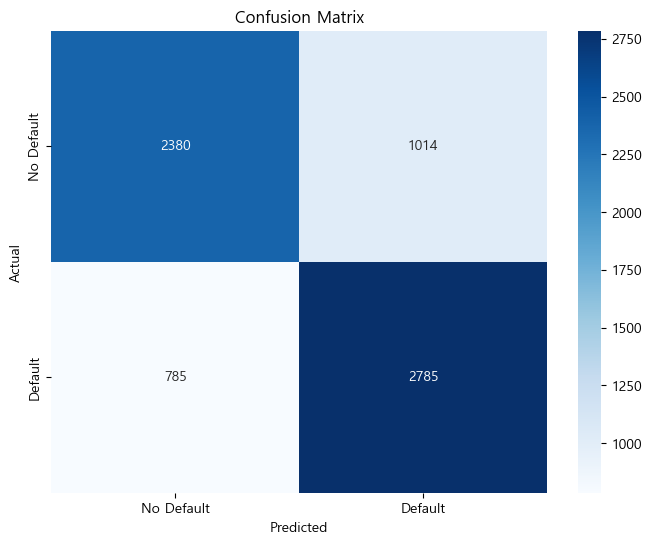

In [90]:
# 신용카드 데이터 결과
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(xgb_ipt_model,  x_val_ipt, y_val)
confusion_mt(y_val, y_pred_rf_p)

Accuracy: 0.7385123492245835
Precision: 0.7432788613600422
Recall: 0.7690209980910826
F1-score: 0.7559308403699236
ROC AUC: 0.8099346415608343


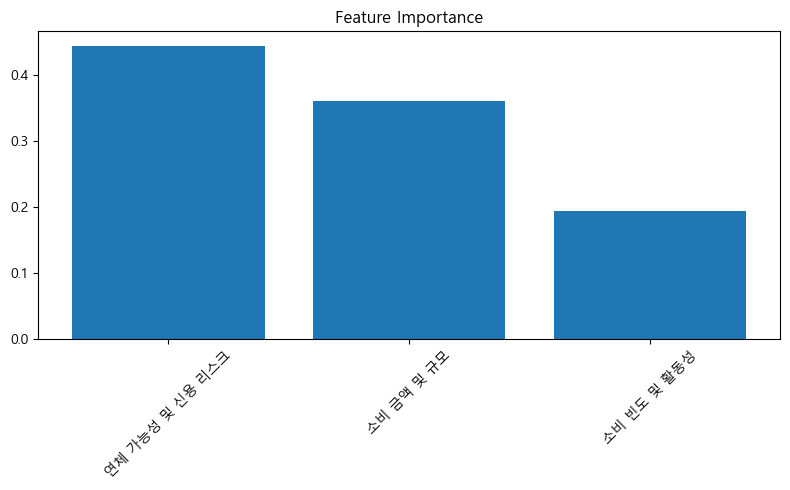

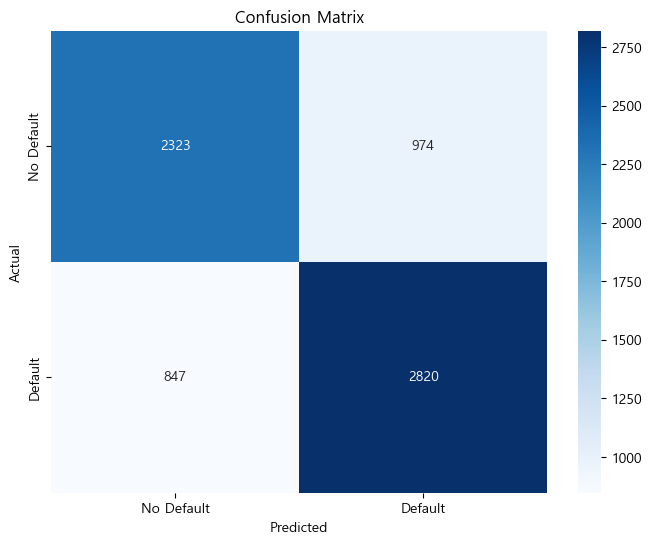

In [91]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(xgb_ipt_model,  x_test_ipt, y_test)
confusion_mt(y_test, y_pred_rf_p)

Accuracy: 0.7419366666666667
Precision: 0.06959152798789713
Recall: 0.00014881578223721882
F1-score: 0.00029699646186823685
ROC AUC: 0.48813213249614346


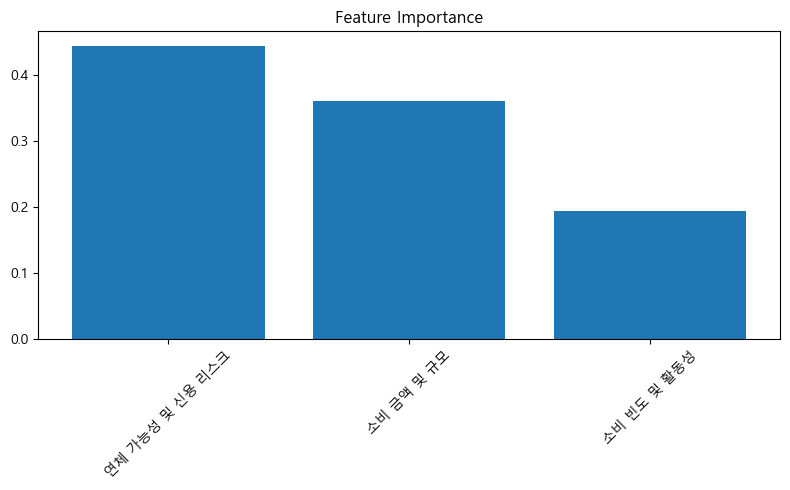

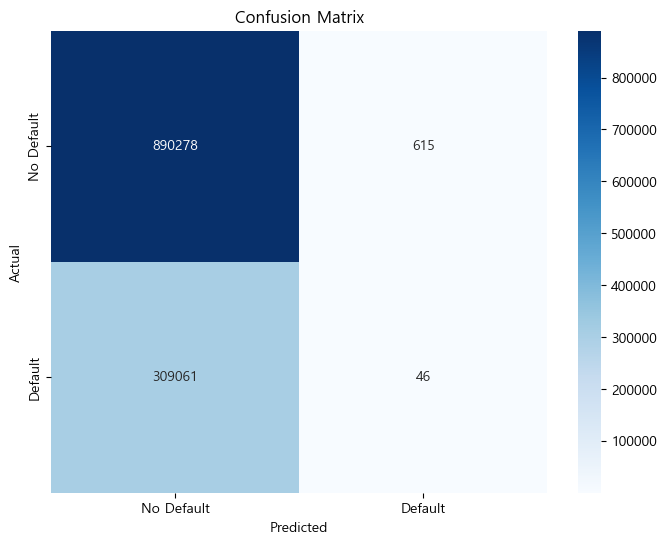

In [92]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(xgb_ipt_model,  x_test_p_ipt, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

In [93]:
rf_ipt_model = rf_grid_model(x_train_ipt, x_val_ipt, y_train, y_val)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
최적의 AUC 점수: 0.8511895329880491


Accuracy: 0.7301838024124067
Precision: 0.6931688371030386
Recall: 0.849859943977591
F1-score: 0.7635585755631056
ROC AUC: 0.8027247375084389


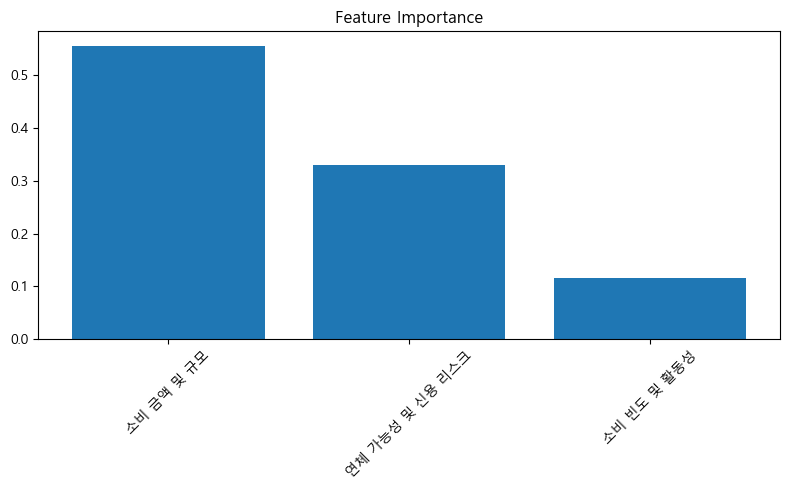

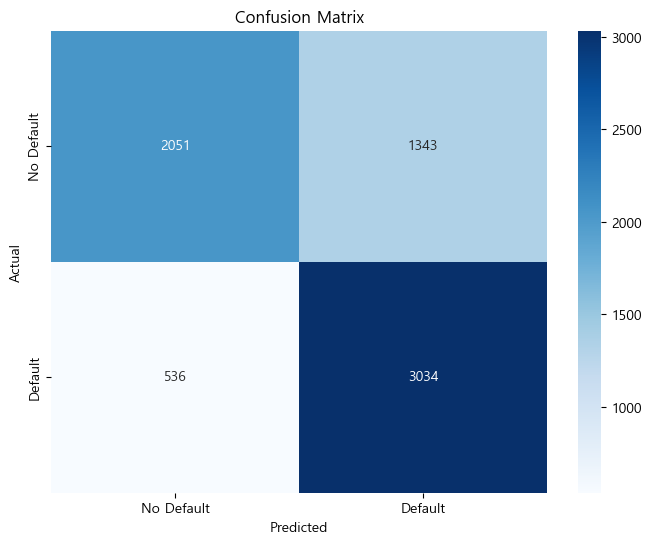

In [94]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(rf_ipt_model,  x_val_ipt, y_val)
confusion_mt(y_val, y_pred_rf_p)

Accuracy: 0.7330557151062608
Precision: 0.7040632054176073
Recall: 0.8505590400872648
F1-score: 0.7704087933802642
ROC AUC: 0.7995126011788654


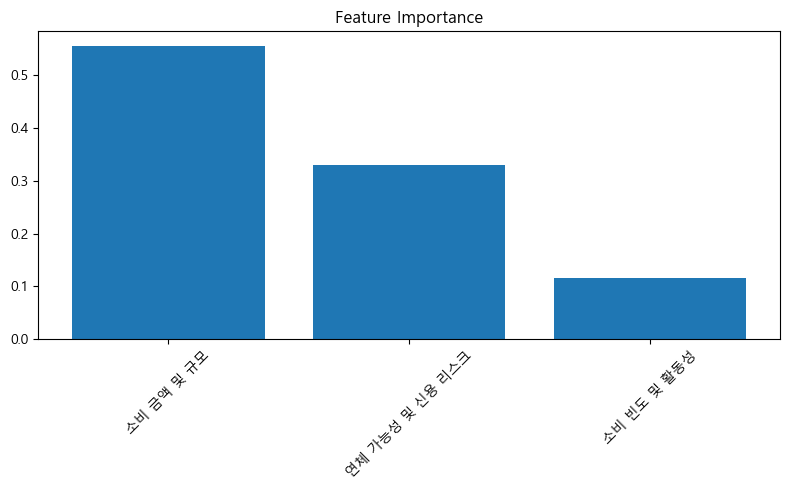

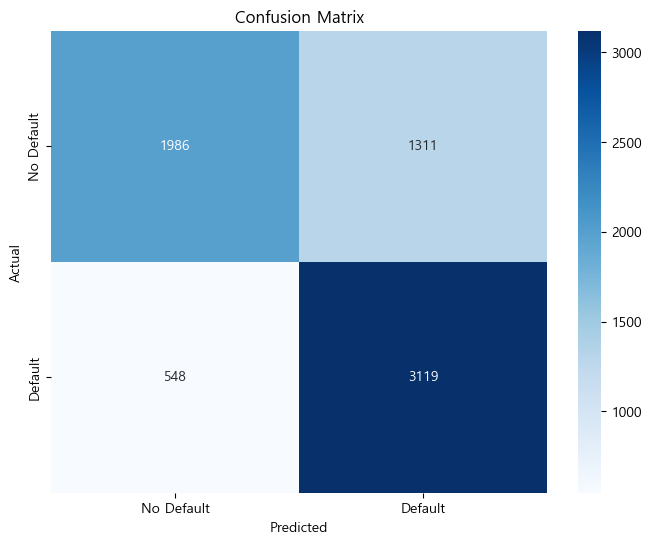

In [95]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(rf_ipt_model,  x_test_ipt, y_test)
confusion_mt(y_test, y_pred_rf_p)

Accuracy: 0.7423941666666667
Precision: 0.11538461538461539
Recall: 9.705377102427314e-06
F1-score: 1.9409121640200174e-05
ROC AUC: 0.4896574346231254


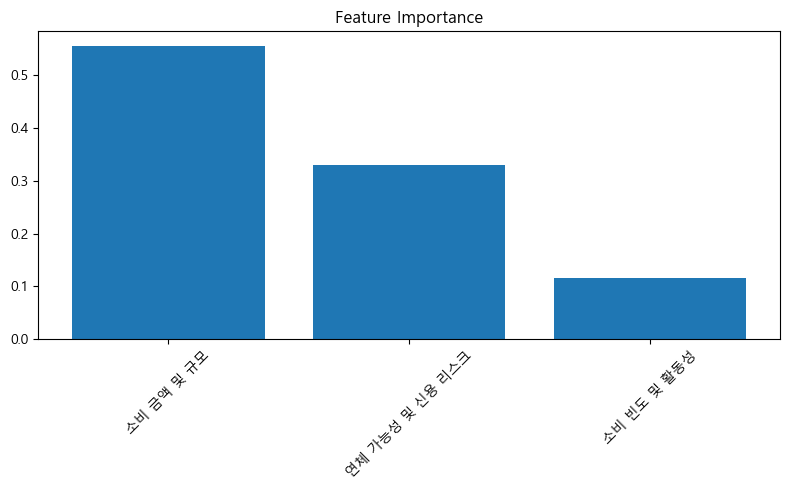

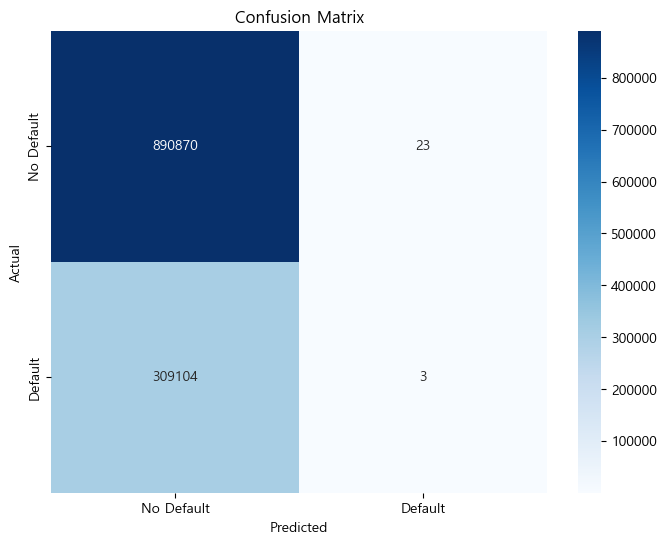

In [96]:
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(rf_ipt_model,  x_test_p_ipt, y_test_p)
confusion_mt(y_test_p, y_pred_rf_p)

### 오토글루온

In [ ]:
# # 대안신용평가 데이터 
# auto_df = copy.deepcopy(alter_avg_raw)

# # 신용카드 데이터


# predictor = TabularPredictor(label='연체여부',
#                             eval_metric='mcc',
#                             problem_type='binary').fit(auto_df,
#                                                        presets='best_quality',
#                                                         time_limit=600,
#                                                        verbosity=1,
#                                                     #    excluded_model_types=['KNN','XGBoost'],
#                                                        ag_args_fit={'num_gpus': 1},
#                                                        auto_stack=True,
# #                                                        num_bag_folds=5,
# #                                                        num_stack_levels=2,
# #                                                        num_bag_sets = 1,
#                                                       )
# results = predictor.fit_summary(verbosity=1)
 

In [ ]:
# # 훈련 리더보드
# predictor.leaderboard()

In [ ]:
# # 모델 예측(라벨값 제외)
# y_pred = predictor.predict(predict_data)

# ## 모델 평가
# evaluation_results = predictor.evaluate(predict_data, silent=True)
# evaluation_results

In [ ]:
# predictor.leaderboard()